# Lab 2

## Original Parameters: 3 Convolutional Layers, 1e-2 Learning Rate, and 2**5 Kernel Length

input layer: Tensor("ExpandDims_1:0", shape=(128, 128, 1, 1), dtype=float32)
input layer is: Tensor("Squeeze:0", shape=(2,), dtype=float32)
iteration: 0
input x is: 0.1640625
output x is: -0.0022220423
input y is: -0.453125
output y is: 0.005909765
error is: 0.23836347
iteration: 1
input x is: 0.3046875
output x is: 0.013652132
input y is: 0.4765625
output y is: -0.008338171
error is: 0.31983024
iteration: 2
input x is: 0.15625
output x is: 0.023436856
input y is: 0.265625
output y is: -0.0075381473
error is: 0.09225743
iteration: 3
input x is: 0.1640625
output x is: 0.032822423
input y is: -0.3359375
output y is: -0.00454551
error is: 0.1270446
iteration: 4
input x is: 0.0390625
output x is: 0.042035494
input y is: -0.3828125
output y is: -0.0047463495
error is: 0.14294285
iteration: 5
input x is: 0.2109375
output x is: 0.049780086
input y is: 0.0703125
output y is: -0.0072476403
error is: 0.031987287
iteration: 6
input x is: 0.0
output x is: 0.057957508
input y is: -0.4609375
output 

iteration: 63
input x is: 0.375
output x is: 0.0171538
input y is: 0.0390625
output y is: -0.02024636
error is: 0.13157144
iteration: 64
input x is: -0.2734375
output x is: 0.020418148
input y is: -0.4375
output y is: -0.020196473
error is: 0.26049337
iteration: 65
input x is: -0.0234375
output x is: 0.022358552
input y is: 0.0546875
output y is: -0.021524776
error is: 0.007905589
iteration: 66
input x is: 0.0234375
output x is: 0.023961602
input y is: -0.140625
output y is: -0.022476425
error is: 0.01395936
iteration: 67
input x is: -0.125
output x is: 0.025413658
input y is: -0.2890625
output y is: -0.023732556
error is: 0.093024254
iteration: 68
input x is: 0.3984375
output x is: 0.02620651
input y is: 0.3046875
output y is: -0.025751248
error is: 0.24774566
iteration: 69
input x is: 0.28125
output x is: 0.02819993
input y is: -0.1015625
output y is: -0.02646296
error is: 0.069674276
iteration: 70
input x is: -0.328125
output x is: 0.030871056
input y is: 0.171875
output y is: -0.02

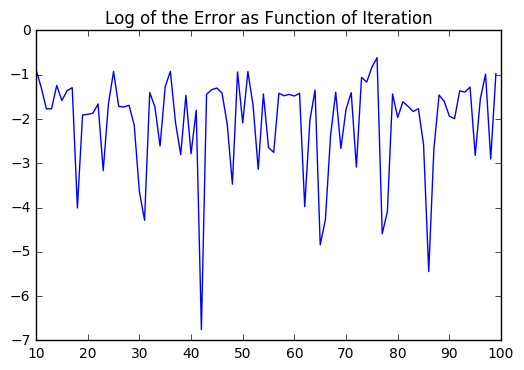

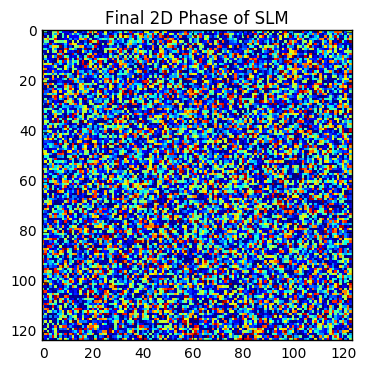

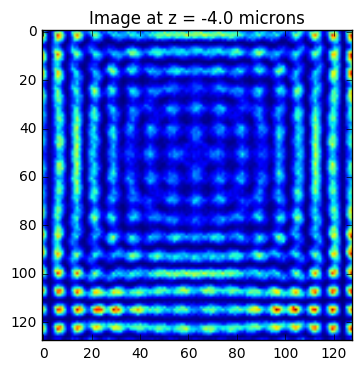

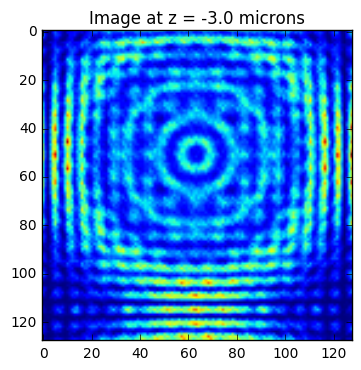

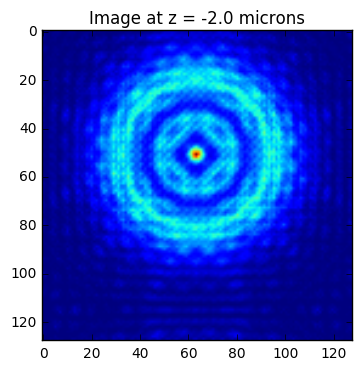

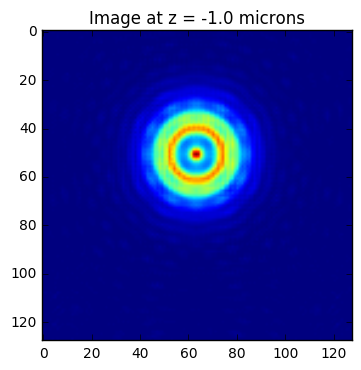

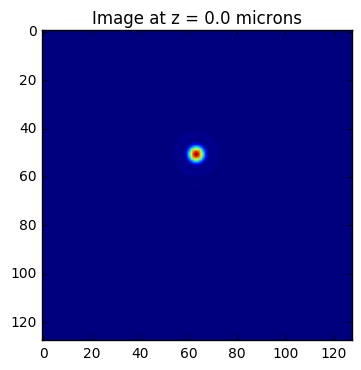

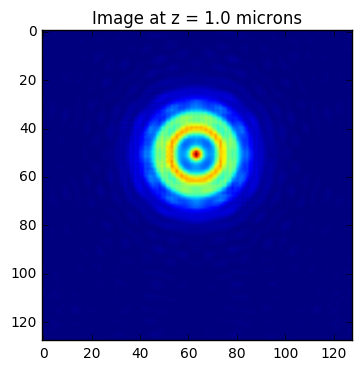

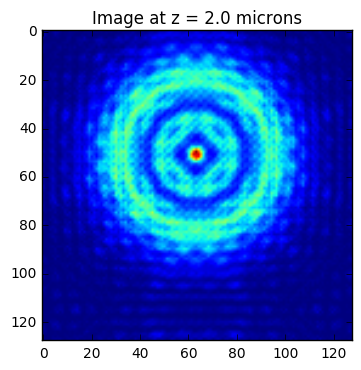

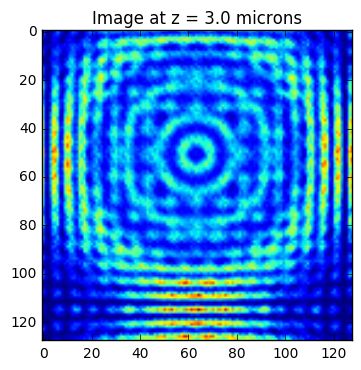

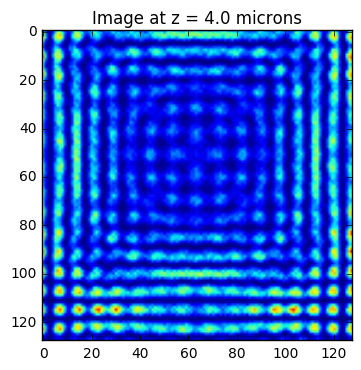

In [1]:
#!/usr/bin/env python
import math
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from E30_Resolution import NAfilter, filter_function_NA, create_point, fresnel_prop
from E30_Tensorflow_Wavelength_Functions import conv_layer, dense_layer

#Parameters
dx = 50e-9
dy = dx
z = 1e-6
kernel_length = 2**5
num_conv_layers = 3
learning_rate = 1e-2
num_iter = 100
xpixels = 2**7
ypixels = xpixels
zpixels = 100
xmax = xpixels / 2
xmin = 0-xmax
ymax = ypixels / 2
ymin = 0-ymax
zmax = 1e-6
zmin = 0-zmax
wavelength = 600e-9
NA  = 1.25
xplot = range(10,num_iter)
yplot = []
pnm = 1e5
L = dx*xpixels
g = np.random.normal(0,.1)
crop=2

slm_in = np.random.rand(xpixels,ypixels)

#TensorFlow optimization graph
with tf.Graph().as_default():
    x = tf.placeholder(tf.float32)
    y = tf.placeholder(tf.float32)
    single_pt_0=tf.placeholder(tf.float32,shape=(xpixels,ypixels))
    
    slm = tf.get_variable('slm',shape=[xpixels,ypixels])
   
    single_pt_2 = tf.expand_dims(single_pt_0, axis = 2)
    single_pt_3 = tf.expand_dims(single_pt_2,axis=3)
    input_layer = single_pt_3
    print('input layer: ' + str(input_layer))
    
    for i in range(num_conv_layers):
        with tf.variable_scope('conv_layer'+str(i)):
            output_layer = conv_layer(kernel_length, input_layer, 1, 1)
            input_layer = output_layer
            
    input_layer = dense_layer(input_layer,xpixels,ypixels,2)
    input_layer = tf.squeeze(input_layer,axis=0)
    print('input layer is: ' + str(input_layer))
    x_guess = input_layer[0]
    y_guess = input_layer[1]
    error = (x - x_guess)**2 + (y - y_guess)**2
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(error)
    
    init_op = tf.global_variables_initializer()

    saver = tf.train.Saver()
    
    x_graph=[]
    y_graph=[]
    
    with tf.Session() as sess:
        sess.run(init_op)
        
        for i in range(num_iter):
            x_a = float(np.random.randint(low=xmin, high=xmax, size=1))/float(xmax*2)
            y_a = float(np.random.randint(low=ymin, high=ymax, size=1))/float(ymax*2)
            a = np.int16(x_a*xmax + xmax/2)
            b = np.int16(y_a*ymax + ymax/2)
            z_vec = np.arange(-4,5,1)*(1e-6)
            z_stack=np.zeros([xpixels,ypixels,len(z_vec)], dtype= np.complex64)
            
            #4F System set-up
            u_0 = create_point(xpixels,ypixels,a,b)
            H_NA = NAfilter(xpixels,L,wavelength,NA)
            u_1 = filter_function_NA(u_0,H_NA,xpixels,incoherent=False)
            u_1 = np.multiply(u_1,np.exp(np.multiply(slm_in,1j)))
            
            #Intensity
            I = abs(u_1)**2
            
            #Poisson noise  
            def poisson(I,pnm,g):
                for i in np.arange(0, xpixels):
                    for j in np.arange(0, ypixels):
                        if I[i][j]>=0:
                            I[i][j]=(np.sqrt(I[i][j]*pnm)*g+I[i][j]*pnm)/pnm
                        else:
                            I[i][j]==0
                return np.float32(I)
                       
            I = pnm*I
            I = poisson(I,pnm,g)
            I = I.astype(float)
            I = I/pnm
            
            spt = I
            [_,error_0,x_1,y_1,x_in,y_in,slm_in]= sess.run([train,error,x_guess,y_guess,x,y,slm],feed_dict = {x:x_a,y:y_a, single_pt_0:spt})
            
            x_graph.append(x_1)
            y_graph.append(y_1)
            
            print('iteration: ' + str(i))
            print('input x is: ' + str(x_a))
            print('output x is: ' + str(x_1))
            print('input y is: ' + str(y_a))
            print('output y is: ' + str(y_1))
            print('error is: ' + str(error_0))
            if i > 9: yplot.append(error_0)
            save_path = saver.save(sess, "/tmp/model.ckpt")
            
        a = np.int16(xpixels/2)
        b = np.int16(ypixels/2)
        z_vec = np.arange(-4,5,1)*(1e-6)
        z_stack=np.zeros([xpixels,ypixels,len(z_vec)], dtype= np.complex64)
            
#Error log plot            
plt.figure()
plt.title ('Log of the Error as Function of Iteration')
plt.plot(xplot,np.log(yplot), 'b')
plt.show()

#Final 2D phase of SLM
plt.figure()
plt.imshow(np.abs(slm_in[crop:-crop,crop:-crop])**2, interpolation = 'none')
plt.title('Final 2D Phase of SLM')   
plt.show()

#2D Image of a point for every z-distance
for z in z_vec:
    u_f = fresnel_prop(u_1,dx,dy,z,wavelength)
    plt.figure()
    plt.imshow(np.abs(u_f)**2)
    plt.title('Image at z = ' + str(z*10**6) + ' microns')   
    plt.show()


# Learning Rate: 1e-1

input layer: Tensor("ExpandDims_1:0", shape=(128, 128, 1, 1), dtype=float32)
input layer is: Tensor("Squeeze:0", shape=(2,), dtype=float32)
iteration: 0
input x is: 0.0625
output x is: 0.003943975
input y is: -0.4140625
output y is: 0.0027542245
error is: 0.17716497
iteration: 1
input x is: 0.0078125
output x is: 0.10394369
input y is: -0.40625
output y is: -0.097245745
error is: 0.10472483
iteration: 2
input x is: 0.046875
output x is: 0.07522805
input y is: 0.2421875
output y is: -0.19539395
error is: 0.19228142
iteration: 3
input x is: 0.0390625
output x is: 0.03809115
input y is: -0.3984375
output y is: -0.21216819
error is: 0.0346972
iteration: 4
input x is: -0.421875
output x is: 0.008158622
input y is: -0.375
output y is: -0.2408112
error is: 0.20293556
iteration: 5
input x is: -0.0625
output x is: -0.051094443
input y is: 0.2265625
output y is: -0.2748213
error is: 0.25151578
iteration: 6
input x is: 0.40625
output x is: -0.10348342
input y is: -0.375
output y is: -0.26885137
e

iteration: 63
input x is: 0.3984375
output x is: -0.1380087
input y is: 0.4140625
output y is: 0.14909114
error is: 0.35798436
iteration: 64
input x is: 0.3125
output x is: -0.15965419
input y is: 0.375
output y is: 0.1568086
error is: 0.27053708
iteration: 65
input x is: -0.3828125
output x is: -0.16313541
input y is: 0.2734375
output y is: 0.17101778
error is: 0.058747824
iteration: 66
input x is: -0.28125
output x is: -0.17363973
input y is: -0.375
output y is: 0.18731491
error is: 0.32777804
iteration: 67
input x is: 0.21875
output x is: -0.18678631
input y is: -0.03125
output y is: 0.18327942
error is: 0.21048257
iteration: 68
input x is: 0.1875
output x is: -0.18495242
input y is: -0.3203125
output y is: 0.17257796
error is: 0.38166183
iteration: 69
input x is: -0.2265625
output x is: -0.17088236
input y is: -0.3984375
output y is: 0.14704661
error is: 0.30065322
iteration: 70
input x is: -0.453125
output x is: -0.15999982
input y is: 0.203125
output y is: 0.10697454
error is: 0.

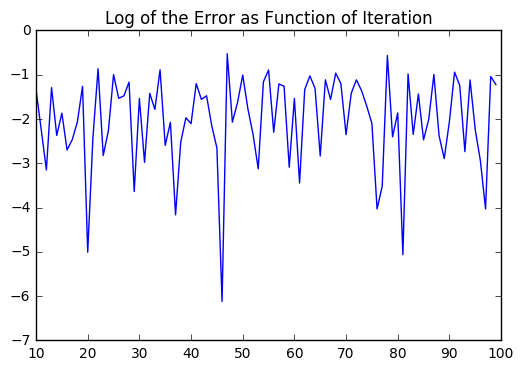

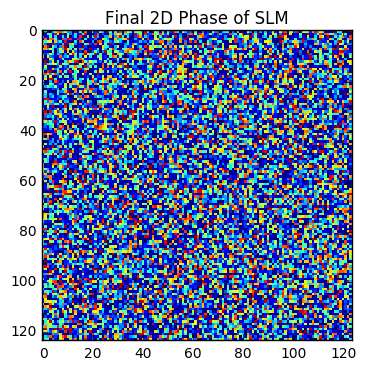

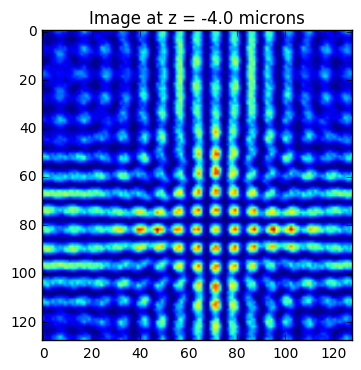

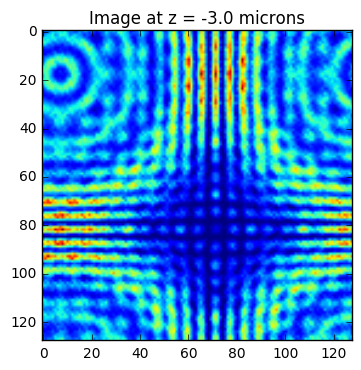

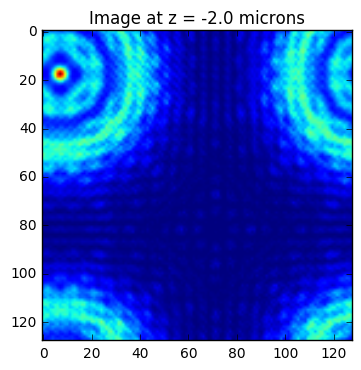

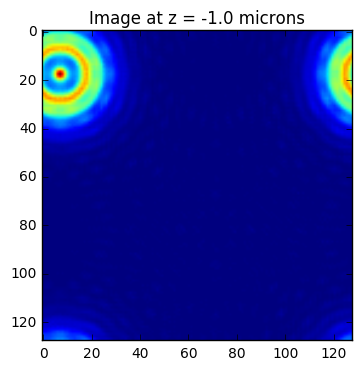

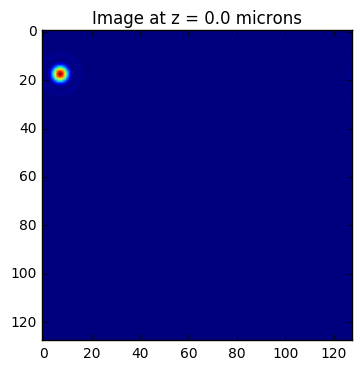

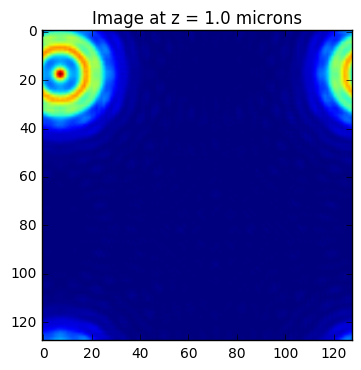

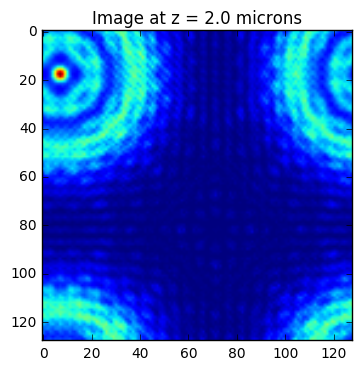

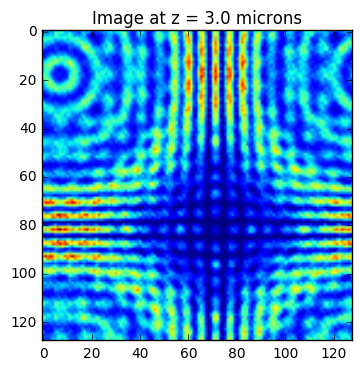

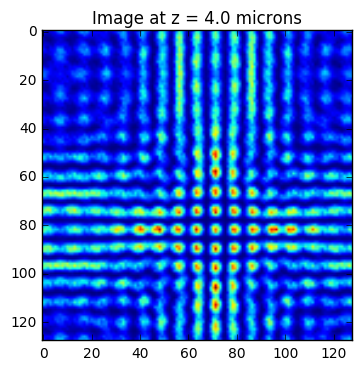

In [2]:
#!/usr/bin/env python
import math
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from E30_Resolution import NAfilter, filter_function_NA, create_point, fresnel_prop
from E30_Tensorflow_Wavelength_Functions import conv_layer, dense_layer

#Parameters
dx = 50e-9
dy = dx
z = 1e-6
kernel_length = 2**5
num_conv_layers = 3
learning_rate = 1e-1
num_iter = 100
xpixels = 2**7
ypixels = xpixels
zpixels = 20
xmax = xpixels / 2
xmin = 0-xmax
ymax = ypixels / 2
ymin = 0-ymax
zmax = 1e-6
zmin = 0-zmax
wavelength = 600e-9
NA  = 1.25
xplot = range(10,num_iter)
yplot = []
pnm = 1e5
L = dx*xpixels
g = np.random.normal(0,.1)
crop=2

slm_in = np.random.rand(xpixels,ypixels)

#TensorFlow optimization graph
with tf.Graph().as_default():
    x = tf.placeholder(tf.float32)
    y = tf.placeholder(tf.float32)
    single_pt_0=tf.placeholder(tf.float32,shape=(xpixels,ypixels))
    
    slm = tf.get_variable('slm',shape=[xpixels,ypixels])
   
    single_pt_2 = tf.expand_dims(single_pt_0, axis = 2)
    single_pt_3 = tf.expand_dims(single_pt_2,axis=3)
    input_layer = single_pt_3
    print('input layer: ' + str(input_layer))
    
    for i in range(num_conv_layers):
        with tf.variable_scope('conv_layer'+str(i)):
            output_layer = conv_layer(kernel_length, input_layer, 1, 1)
            input_layer = output_layer
            
    input_layer = dense_layer(input_layer,xpixels,ypixels,2)
    input_layer = tf.squeeze(input_layer,axis=0)
    print('input layer is: ' + str(input_layer))
    x_guess = input_layer[0]
    y_guess = input_layer[1]
    error = (x - x_guess)**2 + (y - y_guess)**2
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(error)
    
    init_op = tf.global_variables_initializer()

    saver = tf.train.Saver()
    
    x_graph=[]
    y_graph=[]
    
    with tf.Session() as sess:
        sess.run(init_op)
        
        for i in range(num_iter):
            x_a = float(np.random.randint(low=xmin, high=xmax, size=1))/float(xmax*2)
            y_a = float(np.random.randint(low=ymin, high=ymax, size=1))/float(ymax*2)
            a = np.int16(x_a*xmax + xmax/2)
            b = np.int16(y_a*ymax + ymax/2)
            z_vec = np.arange(-4,5,1)*(1e-6)
            z_stack=np.zeros([xpixels,ypixels,len(z_vec)], dtype= np.complex64)
            
            #4F System set-up
            u_0 = create_point(xpixels,ypixels,a,b)
            H_NA = NAfilter(xpixels,L,wavelength,NA)
            u_1 = filter_function_NA(u_0,H_NA,xpixels,incoherent=False)
            u_1 = np.multiply(u_1,np.exp(np.multiply(slm_in,1j)))
            
            #Intensity
            I = abs(u_1)**2
            
            #Poisson noise  
            def poisson(I,pnm,g):
                for i in np.arange(0, xpixels):
                    for j in np.arange(0, ypixels):
                        if I[i][j]>=0:
                            I[i][j]=(np.sqrt(I[i][j]*pnm)*g+I[i][j]*pnm)/pnm
                        else:
                            I[i][j]==0
                return np.float32(I)
                       
            I = pnm*I
            I = poisson(I,pnm,g)
            I = I.astype(float)
            I = I/pnm
            
            spt = I
            [_,error_0,x_1,y_1,x_in,y_in,slm_in]= sess.run([train,error,x_guess,y_guess,x,y,slm],feed_dict = {x:x_a,y:y_a, single_pt_0:spt})
            
            x_graph.append(x_1)
            y_graph.append(y_1)
            
            print('iteration: ' + str(i))
            print('input x is: ' + str(x_a))
            print('output x is: ' + str(x_1))
            print('input y is: ' + str(y_a))
            print('output y is: ' + str(y_1))
            print('error is: ' + str(error_0))
            if i > 9: yplot.append(error_0)
            save_path = saver.save(sess, "/tmp/model.ckpt")
            
        a = np.int16(xpixels/2)
        b = np.int16(ypixels/2)
        z_vec = np.arange(-4,5,1)*(1e-6)
        z_stack=np.zeros([xpixels,ypixels,len(z_vec)], dtype= np.complex64)
            
#Error log plot            
plt.figure()
plt.title ('Log of the Error as Function of Iteration')
plt.plot(xplot,np.log(yplot), 'b')
plt.show()

#Final 2D phase of SLM
plt.figure()
plt.imshow(np.abs(slm_in[crop:-crop,crop:-crop])**2, interpolation = 'none')
plt.title('Final 2D Phase of SLM')   
plt.show()

#2D Image of a point for every z-distance
for z in z_vec:
    u_f = fresnel_prop(u_1,dx,dy,z,wavelength)
    plt.figure()
    plt.imshow(np.abs(u_f)**2)
    plt.title('Image at z = ' + str(z*10**6) + ' microns')   
    plt.show()


# Learning Rate: 1e-3

input layer: Tensor("ExpandDims_1:0", shape=(128, 128, 1, 1), dtype=float32)
input layer is: Tensor("Squeeze:0", shape=(2,), dtype=float32)
iteration: 0
input x is: 0.015625
output x is: 0.0009968643
input y is: 0.125
output y is: 0.0022202039
error is: 0.015288861
iteration: 1
input x is: -0.3515625
output x is: 0.17143066
input y is: -0.1015625
output y is: 0.1731487
error is: 0.3489881
iteration: 2
input x is: -0.2890625
output x is: 0.041368734
input y is: 0.1328125
output y is: 0.08225977
error is: 0.11174037
iteration: 3
input x is: 0.203125
output x is: -0.06860043
input y is: 0.03125
output y is: 0.038335487
error is: 0.073884904
iteration: 4
input x is: 0.2890625
output x is: -0.10704063
input y is: -0.2421875
output y is: 0.008060817
error is: 0.21952191
iteration: 5
input x is: -0.1171875
output x is: -0.09731514
input y is: 0.359375
output y is: -0.03239837
error is: 0.15388128
iteration: 6
input x is: -0.0390625
output x is: -0.08174773
input y is: -0.296875
output y is: -

iteration: 63
input x is: -0.5
output x is: 0.003184416
input y is: -0.21875
output y is: 0.012244407
error is: 0.30655298
iteration: 64
input x is: -0.484375
output x is: 0.0028936572
input y is: -0.1953125
output y is: 0.0123707885
error is: 0.2805631
iteration: 65
input x is: -0.3125
output x is: 0.0024067648
input y is: 0.0859375
output y is: 0.012351439
error is: 0.104581185
iteration: 66
input x is: 0.4765625
output x is: 0.0018264939
input y is: 0.3046875
output y is: 0.012374794
error is: 0.310821
iteration: 67
input x is: -0.140625
output x is: 0.0015274368
input y is: 0.4375
output y is: 0.012576884
error is: 0.20076698
iteration: 68
input x is: -0.078125
output x is: 0.001193044
input y is: -0.3046875
output y is: 0.013017943
error is: 0.10722811
iteration: 69
input x is: -0.1796875
output x is: 0.00085146865
input y is: -0.109375
output y is: 0.013218706
error is: 0.047623537
iteration: 70
input x is: -0.1171875
output x is: 0.00045862215
input y is: 0.3828125
output y is: 

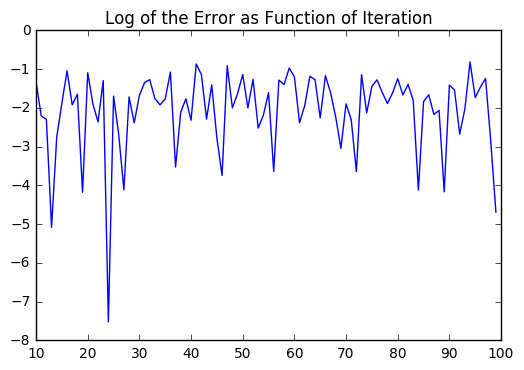

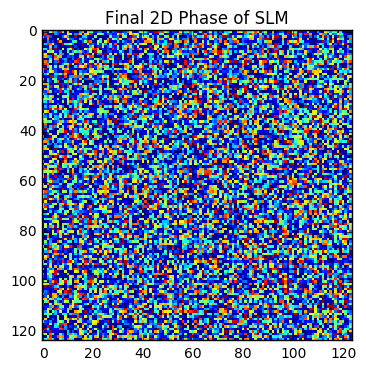

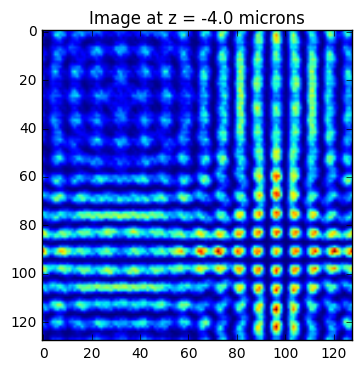

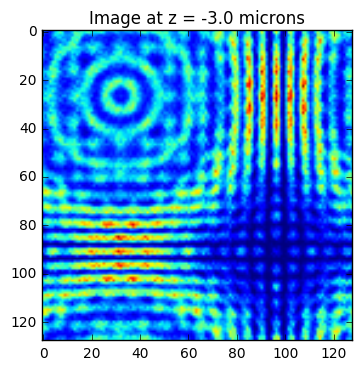

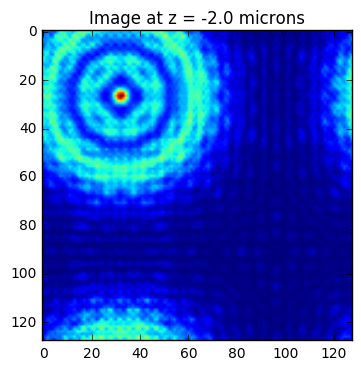

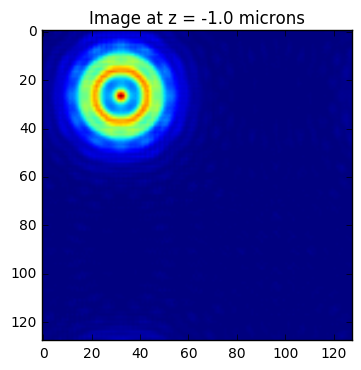

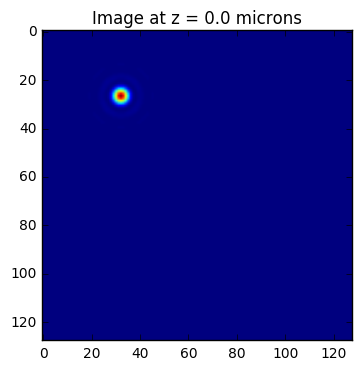

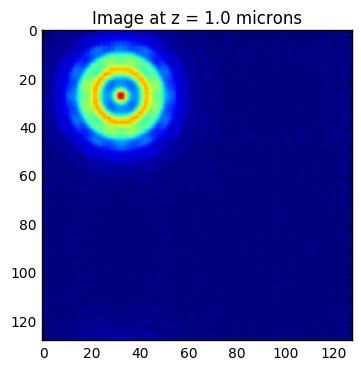

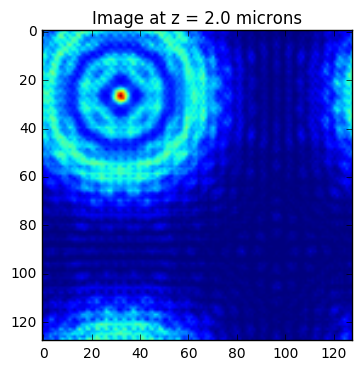

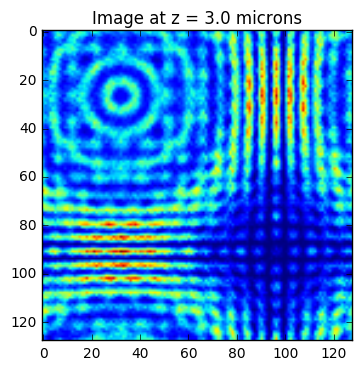

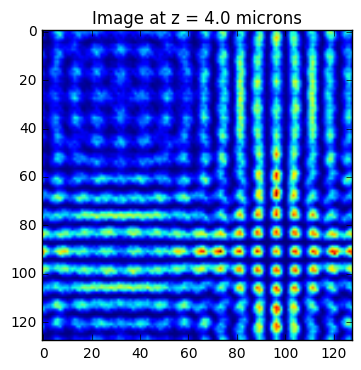

In [3]:
#!/usr/bin/env python
import math
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from E30_Resolution import NAfilter, filter_function_NA, create_point, fresnel_prop
from E30_Tensorflow_Wavelength_Functions import conv_layer, dense_layer

#Parameters
dx = 50e-9
dy = dx
z = 1e-6
kernel_length = 2**5
num_conv_layers = 3
learning_rate = 1e-3
num_iter = 100
xpixels = 2**7
ypixels = xpixels
zpixels = 20
xmax = xpixels / 2
xmin = 0-xmax
ymax = ypixels / 2
ymin = 0-ymax
zmax = 1e-6
zmin = 0-zmax
wavelength = 600e-9
NA  = 1.25
xplot = range(10,num_iter)
yplot = []
pnm = 1e5
L = dx*xpixels
g = np.random.normal(0,.1)
crop=2

slm_in = np.random.rand(xpixels,ypixels)

#TensorFlow optimization graph
with tf.Graph().as_default():
    x = tf.placeholder(tf.float32)
    y = tf.placeholder(tf.float32)
    single_pt_0=tf.placeholder(tf.float32,shape=(xpixels,ypixels))
    
    slm = tf.get_variable('slm',shape=[xpixels,ypixels])
   
    single_pt_2 = tf.expand_dims(single_pt_0, axis = 2)
    single_pt_3 = tf.expand_dims(single_pt_2,axis=3)
    input_layer = single_pt_3
    print('input layer: ' + str(input_layer))
    
    for i in range(num_conv_layers):
        with tf.variable_scope('conv_layer'+str(i)):
            output_layer = conv_layer(kernel_length, input_layer, 1, 1)
            input_layer = output_layer
            
    input_layer = dense_layer(input_layer,xpixels,ypixels,2)
    input_layer = tf.squeeze(input_layer,axis=0)
    print('input layer is: ' + str(input_layer))
    x_guess = input_layer[0]
    y_guess = input_layer[1]
    error = (x - x_guess)**2 + (y - y_guess)**2
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(error)
    
    init_op = tf.global_variables_initializer()

    saver = tf.train.Saver()
    
    x_graph=[]
    y_graph=[]
    
    with tf.Session() as sess:
        sess.run(init_op)
        
        for i in range(num_iter):
            x_a = float(np.random.randint(low=xmin, high=xmax, size=1))/float(xmax*2)
            y_a = float(np.random.randint(low=ymin, high=ymax, size=1))/float(ymax*2)
            a = np.int16(x_a*xmax + xmax/2)
            b = np.int16(y_a*ymax + ymax/2)
            z_vec = np.arange(-4,5,1)*(1e-6)
            z_stack=np.zeros([xpixels,ypixels,len(z_vec)], dtype= np.complex64)
            
            #4F System set-up
            u_0 = create_point(xpixels,ypixels,a,b)
            H_NA = NAfilter(xpixels,L,wavelength,NA)
            u_1 = filter_function_NA(u_0,H_NA,xpixels,incoherent=False)
            u_1 = np.multiply(u_1,np.exp(np.multiply(slm_in,1j)))
            
            #Intensity
            I = abs(u_1)**2
            
            #Poisson noise  
            def poisson(I,pnm,g):
                for i in np.arange(0, xpixels):
                    for j in np.arange(0, ypixels):
                        if I[i][j]>=0:
                            I[i][j]=(np.sqrt(I[i][j]*pnm)*g+I[i][j]*pnm)/pnm
                        else:
                            I[i][j]==0
                return np.float32(I)
                       
            I = pnm*I
            I = poisson(I,pnm,g)
            I = I.astype(float)
            I = I/pnm
            
            spt = I
            [_,error_0,x_1,y_1,x_in,y_in,slm_in]= sess.run([train,error,x_guess,y_guess,x,y,slm],feed_dict = {x:x_a,y:y_a, single_pt_0:spt})
            
            x_graph.append(x_1)
            y_graph.append(y_1)
            
            print('iteration: ' + str(i))
            print('input x is: ' + str(x_a))
            print('output x is: ' + str(x_1))
            print('input y is: ' + str(y_a))
            print('output y is: ' + str(y_1))
            print('error is: ' + str(error_0))
            if i > 9: yplot.append(error_0)
            save_path = saver.save(sess, "/tmp/model.ckpt")
            
        a = np.int16(xpixels/2)
        b = np.int16(ypixels/2)
        z_vec = np.arange(-4,5,1)*(1e-6)
        z_stack=np.zeros([xpixels,ypixels,len(z_vec)], dtype= np.complex64)
            
#Error log plot            
plt.figure()
plt.title ('Log of the Error as Function of Iteration')
plt.plot(xplot,np.log(yplot), 'b')
plt.show()

#Final 2D phase of SLM
plt.figure()
plt.imshow(np.abs(slm_in[crop:-crop,crop:-crop])**2, interpolation = 'none')
plt.title('Final 2D Phase of SLM')   
plt.show()

#2D Image of a point for every z-distance
for z in z_vec:
    u_f = fresnel_prop(u_1,dx,dy,z,wavelength)
    plt.figure()
    plt.imshow(np.abs(u_f)**2)
    plt.title('Image at z = ' + str(z*10**6) + ' microns')   
    plt.show()


# Convolutional Layers: 2

In [ ]:
#

# Convolutional Layers: 4

input layer: Tensor("ExpandDims_1:0", shape=(128, 128, 1, 1), dtype=float32)
input layer is: Tensor("Squeeze:0", shape=(2,), dtype=float32)
iteration: 0
input x is: 0.3984375
output x is: -0.02149712
input y is: 0.0390625
output y is: -0.022350587
error is: 0.18011667
iteration: 1
input x is: -0.2578125
output x is: 1.1672388
input y is: -0.078125
output y is: 1.1785775
error is: 3.6100726
iteration: 2
input x is: -0.2890625
output x is: -0.0023160018
input y is: -0.4296875
output y is: 0.01613047
error is: 0.28097722
iteration: 3
input x is: -0.390625
output x is: -0.007508132
input y is: -0.09375
output y is: 0.008819062
error is: 0.15729895
iteration: 4
input x is: -0.2421875
output x is: -0.0130586615
input y is: 0.4296875
output y is: 0.002401975
error is: 0.23507294
iteration: 5
input x is: 0.484375
output x is: -0.01849366
input y is: 0.21875
output y is: -0.0011037353
error is: 0.30121255
iteration: 6
input x is: -0.28125
output x is: -0.021367356
input y is: -0.265625
output y

iteration: 63
input x is: -0.3046875
output x is: -0.015007809
input y is: 0.359375
output y is: -0.0033101058
error is: 0.21545482
iteration: 64
input x is: -0.0546875
output x is: -0.0160665
input y is: -0.0703125
output y is: -0.0033582416
error is: 0.005974454
iteration: 65
input x is: 0.0390625
output x is: -0.017138405
input y is: 0.3671875
output y is: -0.0036046337
error is: 0.14064534
iteration: 66
input x is: 0.4140625
output x is: -0.017946769
input y is: -0.0234375
output y is: -0.002705517
error is: 0.18706183
iteration: 67
input x is: 0.3359375
output x is: -0.01741851
input y is: 0.0234375
output y is: -0.0019532267
error is: 0.12550515
iteration: 68
input x is: -0.046875
output x is: -0.015919294
input y is: 0.2734375
output y is: -0.0011931544
error is: 0.07638026
iteration: 69
input x is: 0.4140625
output x is: -0.014650335
input y is: -0.4765625
output y is: 0.0003366588
error is: 0.41122752
iteration: 70
input x is: -0.0859375
output x is: -0.012266744
input y is: -

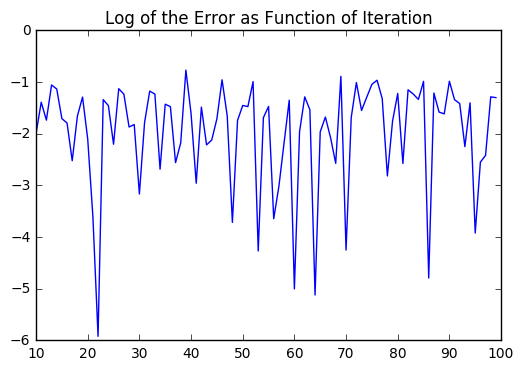

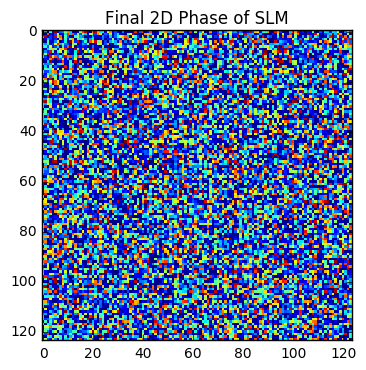

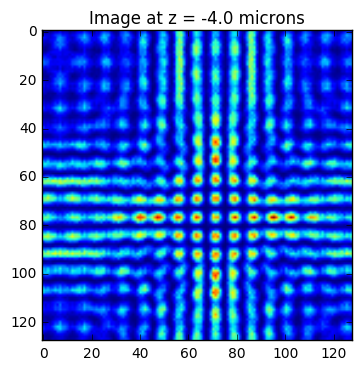

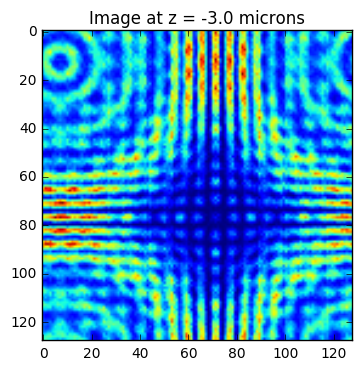

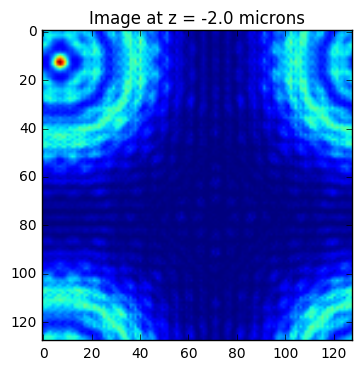

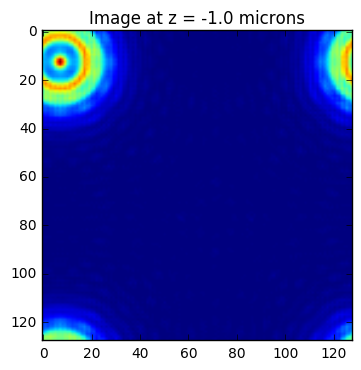

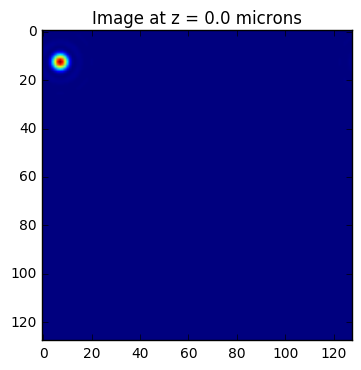

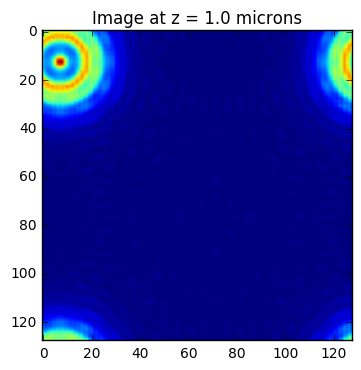

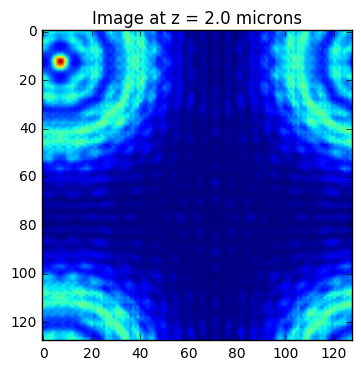

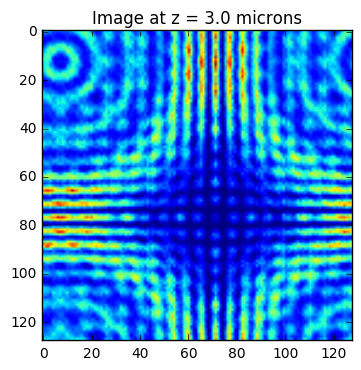

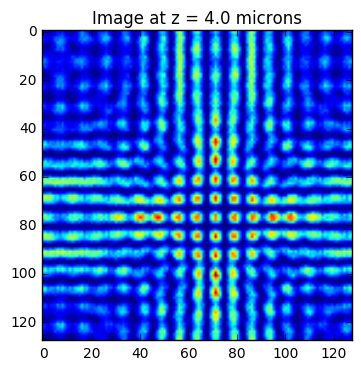

In [5]:
#